# HeartPredict

HeartPredict is a Python library designed to analyze
and predict heart failure outcomes using patient data.

## Dataset information

The dataset used for this analysis was obtained from kaggle.com.
It contains 5000 medical records of patients who had heart-failure
and is licensed under CC0; made available under [this URL](https://www.kaggle.com/datasets/aadarshvelu/heart-failure-prediction-clinical-records).


In [15]:
from heartpredict.backend.data import ProjectData, MLData
from heartpredict.backend.survival import SurvivalBackend

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [16]:
seed = 42
project_data = ProjectData(Path("../data/heart_failure_clinical_records.csv"))
ml_data = MLData(project_data, 0.2, seed)

### Descriptive Analysis

- What are the basic statistics (mean, median, standard deviation)
  of the clinical features?
- How is the age distribution of patients?
- What is the proportion of patients with conditions like anaemia, diabetes
  and high blood pressure?

### Correlation and Feature Importance

- Which clinical features are most strongly correlated with the DEATH_EVENT?
  And what are the most important features for predicting heart failure outcomes?
- How do different clinical features contribute
  to the risk of death due to heart failure?

### Predictive Analysis

- How accurately can we predict DEATH_EVENT using clinical features?
- Which machine learning model performs best for this prediction task?
  (We can use DecisionTrees, RandomForest or other classifiers) Let us use scikit-learn
- How do different models compare in terms of accuracy, precision, recall
  and other metrics?

### Survival Analysis

- Can we identify patient subgroups with higher or lower survival probabilities? 
- And what is the survival rate of patients over the follow-up period?

We can use Kaplan-Meier survival curves to visualize the survival probabilities of patients with different clinical features.
This will help us understand how different risk factors affect patient outcomes.

Therefore, we used a regression model to predict the survival probability of the patients.
Then we assign the patients to high-risk, medium-risk and low-risk groups based on their predicted survival probabilities.
For each group, we generate a Kaplan-Meier survival curve to visualize the survival probabilities over time.

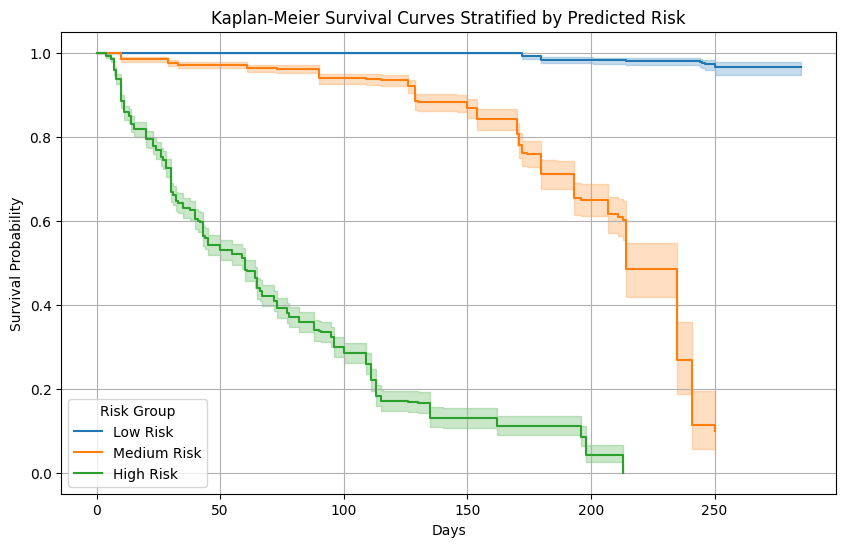

Kaplan-Meier plot saved to results/survival/kaplan_meier_plot.png


In [17]:
regressor = "../results/trained_models/regressor/LogisticRegression_model_42.joblib"

survival_backend = SurvivalBackend(ml_data)
survival_backend.create_kaplan_meier_plot_for(regressor, show_plot=True)

### Risk Factor Analysis

- How does smoking affect the risk of death in heart failure patients?
- What is the impact of serum creatinine and serum sodium levels on patient outcomes?
- How does the combination of multiple risk factors affect the likelihood
  of heart failure-related death?